In [27]:
import os.path as osp

import PIL.Image as PImage
from torchvision.datasets.folder import DatasetFolder, IMG_EXTENSIONS
from torchvision.transforms import InterpolationMode, transforms

import os
import os.path as osp
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

import gc
import os
import shutil
import sys
import time
import warnings
from functools import partial

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import stats

In [28]:
class NPYImageDataset(Dataset):
    def __init__(self, npy_path, image_dir, transform=None):
        self.data = np.load(npy_path)
        self.image_dir = image_dir
        self.transform = transform
        
        assert self.data.shape[1] == 1025, f"数据形状应为(n, 1025)，但得到{self.data.shape}"
        
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.tiff', '.jpg', '.jpeg', '.bmp'))]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        latent_vector = self.data[idx, :1024] 
        image_label = int(self.data[idx, 1024]) 
        
        image_path = osp.join(self.image_dir, f"natural_scene_{image_label}.tiff")
        
        try:
            img = Image.open(image_path).convert('L') 
        except FileNotFoundError:
            img = Image.new('L', (256, 256), color=0)
            print(f"Warning: image {image_path} disappear")
        
        if self.transform:
            img = self.transform(img)
        
        latent_vector = torch.tensor(latent_vector, dtype=torch.float32)
        #img = torch.tensor(img, dtype=torch.float32)

        return img, latent_vector

def build_dataset(
    data_path: str, 
    final_reso: int
):
    transform = transforms.Compose([
        transforms.Resize((final_reso, final_reso)),  
        transforms.ToTensor(),                       
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Lambda(lambda x: x * 2 - 1)         
    ])
    
    train_set = NPYImageDataset(
        npy_path=osp.join(data_path, 'VISp_train_features.npy'),
        image_dir=osp.join('/media/ubuntu/sda/neuropixels/nature_scene'),
        transform=transform
    )
    
    val_set = NPYImageDataset(
        npy_path=osp.join(data_path, 'VISp_eval_features.npy'),
        image_dir=osp.join('/media/ubuntu/sda/neuropixels/nature_scene'),
        transform=transform
    )
    
    num_classes = 1000  
    
    return num_classes, train_set, val_set

In [29]:
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====


# download checkpoint
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'

# build vae, var
FOR_512_px = MODEL_DEPTH == 16
# if FOR_512_px:
#     patch_nums = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
# else:
#     patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)

patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px,
)

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=False)



[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422


_IncompatibleKeys(missing_keys=['shared_ada_lin.1.weight', 'shared_ada_lin.1.bias', 'blocks.0.ada_gss', 'blocks.1.ada_gss', 'blocks.2.ada_gss', 'blocks.3.ada_gss', 'blocks.4.ada_gss', 'blocks.5.ada_gss', 'blocks.6.ada_gss', 'blocks.7.ada_gss', 'blocks.8.ada_gss', 'blocks.9.ada_gss', 'blocks.10.ada_gss', 'blocks.11.ada_gss', 'blocks.12.ada_gss', 'blocks.13.ada_gss', 'blocks.14.ada_gss', 'blocks.15.ada_gss'], unexpected_keys=['blocks.0.ada_lin.1.weight', 'blocks.0.ada_lin.1.bias', 'blocks.1.ada_lin.1.weight', 'blocks.1.ada_lin.1.bias', 'blocks.2.ada_lin.1.weight', 'blocks.2.ada_lin.1.bias', 'blocks.3.ada_lin.1.weight', 'blocks.3.ada_lin.1.bias', 'blocks.4.ada_lin.1.weight', 'blocks.4.ada_lin.1.bias', 'blocks.5.ada_lin.1.weight', 'blocks.5.ada_lin.1.bias', 'blocks.6.ada_lin.1.weight', 'blocks.6.ada_lin.1.bias', 'blocks.7.ada_lin.1.weight', 'blocks.7.ada_lin.1.bias', 'blocks.8.ada_lin.1.weight', 'blocks.8.ada_lin.1.bias', 'blocks.9.ada_lin.1.weight', 'blocks.9.ada_lin.1.bias', 'blocks.10.a

In [4]:
class TrainingConfig:
    batch_size = 3
    num_workers = 4
    image_size = 256
    dataset_path = "/media/ubuntu/sda/neuropixels/visual_decode"
    
    vae_config = {
        "in_channel": 3,
        "channel": 128,
        "n_res_block": 2,
        "n_res_channel": 64,
        "embed_dim": 64,
        "n_embed": 8192,
        "decay": 0.99
    }
    var_config = {
        "num_classes": 1000,
        "depth": 16,
        "embed_dim": 1024,
        "num_heads": 16,
        "mlp_ratio": 4.0,
        "drop_rate": 0.1,
        "attn_drop_rate": 0.0,
        "drop_path_rate": 0.1,
        "norm_eps": 1e-6,
        "shared_aln": True,
        "cond_drop_rate": 0.1,
        "attn_l2_norm": False,
        "patch_nums": (1, 2, 3, 4, 5, 6, 8, 10, 13, 16),
        "flash_if_available": True,
        "fused_if_available": True,
    }
    
    lr = 1e-4
    weight_decay = 0.05
    betas = (0.9, 0.95)
    
    epochs = 100
    grad_accum = 1
    label_smooth = 0.1
    amp_enabled = True
    
    prog_epochs = 5 
    prog_warmup_iters = 1000  
    
    log_interval = 50
    eval_interval = 1
    save_interval = 5
    checkpoint_dir = "checkpoints"
    log_dir = "logs"
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed = 42

In [5]:
class VARTrainer(object):
    def __init__(
        self, device, patch_nums, resos,
        vae_local, var_model,
        optimizer: torch.optim.Optimizer, label_smooth: float,
        amp_enabled: bool = False
    ):
        super(VARTrainer, self).__init__()
        
        self.var_model = var_model
        self.vae_local = vae_local
        self.quantize_local = vae_local.quantize
        self.optimizer = optimizer
        self.amp_enabled = amp_enabled
        self.device = device
        
        self.var_model.rng = torch.Generator(device=device)
        
        self.label_smooth = label_smooth
        self.train_loss = nn.CrossEntropyLoss(label_smoothing=label_smooth, reduction='none')
        self.val_loss = nn.CrossEntropyLoss(label_smoothing=0.0, reduction='mean')
        
        self.L = sum(pn * pn for pn in patch_nums)
        self.last_l = patch_nums[-1] * patch_nums[-1]
        self.loss_weight = torch.ones(1, self.L, device=device) / self.L
        
        self.patch_nums, self.resos = patch_nums, resos
        self.begin_ends = []
        cur = 0
        for i, pn in enumerate(patch_nums):
            self.begin_ends.append((cur, cur + pn * pn))
            cur += pn*pn
        
        self.prog_it = 0
        self.last_prog_si = -1
        self.first_prog = True
        
        self.scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

    @torch.no_grad()
    def eval_ep(self, ld_val: DataLoader):
        tot = 0
        L_mean, L_tail, acc_mean, acc_tail = 0, 0, 0, 0
        stt = time.time()
        training = self.var_model.training
        self.var_model.eval()
        
        for inp_B3HW, label_B in ld_val:
            B, V = label_B.shape[0], self.vae_local.vocab_size
            inp_B3HW = inp_B3HW.to(self.device)
            label_B = label_B.to(self.device)
            
            gt_idx_Bl: List[torch.Tensor] = self.vae_local.img_to_idxBl(inp_B3HW)
            gt_BL = torch.cat(gt_idx_Bl, dim=1)
            x_BLCv_wo_first_l = self.quantize_local.idxBl_to_var_input(gt_idx_Bl)
            
            logits_BLV = self.var_model(label_B, x_BLCv_wo_first_l)
            
            L_mean += self.val_loss(logits_BLV.view(-1, V), gt_BL.view(-1)).item() * B
            L_tail += self.val_loss(
                logits_BLV[:, -self.last_l:].reshape(-1, V), 
                gt_BL[:, -self.last_l:].reshape(-1)
            ).item() * B
            acc_mean += (logits_BLV.argmax(dim=-1) == gt_BL).float().mean().item() * 100 * B
            acc_tail += (
                logits_BLV[:, -self.last_l:].argmax(dim=-1) == gt_BL[:, -self.last_l:]
            ).float().mean().item() * 100 * B
            tot += B
        
        self.var_model.train(training)
        
        L_mean /= tot
        L_tail /= tot
        acc_mean /= tot
        acc_tail /= tot
        
        return L_mean, L_tail, acc_mean, acc_tail, tot, time.time()-stt

    def train_step(
        self, it: int, g_it: int, stepping: bool,
        inp_B3HW: torch.Tensor, label_B: torch.Tensor, prog_si: int, prog_wp_it: float
    ):
        self.var_model.prog_si = self.vae_local.quantize.prog_si = prog_si
        if self.last_prog_si != prog_si:
            if self.last_prog_si != -1: 
                self.first_prog = False
            self.last_prog_si = prog_si
            self.prog_it = 0
        self.prog_it += 1
        
        prog_wp = max(min(self.prog_it / prog_wp_it, 1), 0.01)
        if self.first_prog: 
            prog_wp = 1
        if prog_si == len(self.patch_nums) - 1: 
            prog_si = -1 

        B, V = label_B.shape[0], self.vae_local.vocab_size
        
        with torch.cuda.amp.autocast(enabled=False):
            gt_idx_Bl = self.vae_local.img_to_idxBl(inp_B3HW)
            gt_BL = torch.cat(gt_idx_Bl, dim=1)
            x_BLCv_wo_first_l = self.quantize_local.idxBl_to_var_input(gt_idx_Bl)
            
            logits_BLV = self.var_model(label_B, x_BLCv_wo_first_l)

            pred_BL = logits_BLV.argmax(dim=-1)
            accuracy = (pred_BL == gt_BL).float().mean().item() * 100
            loss = self.train_loss(logits_BLV.view(-1, V), gt_BL.view(-1)).view(B, -1)
            
            # 应用渐进权重
            if prog_si >= 0:
                bg, ed = self.begin_ends[prog_si]
                lw = self.loss_weight[:, :ed].clone()
                lw[:, bg:ed] *= prog_wp
            else:
                lw = self.loss_weight
                
            loss = loss.mul(lw).sum(dim=-1).mean()

        self.scaler.scale(loss).backward()
        
        grad_norm = 0
        if stepping:
            self.scaler.unscale_(self.optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(
                self.var_model.parameters(), max_norm=1.0
            ).item()
            
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad()
        
        
        self.var_model.prog_si = self.vae_local.quantize.prog_si = -1
        return loss.item(), accuracy, grad_norm, self.scaler.get_scale()

    # ... (get_config, state_dict, load_state_dict 保持不变) ...

In [6]:
def train_single_gpu(config, vae, var_model):
    torch.manual_seed(config.seed)
    if config.device == "cuda":
        torch.cuda.manual_seed_all(config.seed)
    
    num_classes, train_dataset, val_dataset = build_dataset(data_path = config.dataset_path, final_reso = 256)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )

    
    optimizer = torch.optim.AdamW(
        var_model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
        betas=config.betas
    )
    
    trainer = VARTrainer(
        device=config.device,
        patch_nums=config.var_config["patch_nums"],
        resos=(16, 32, 48, 64, 80, 96, 128, 160, 208, 256),
        vae_local=vae,
        var_model=var,
        optimizer=optimizer,
        label_smooth=config.label_smooth,
        amp_enabled=config.amp_enabled
    )
    
    
    global_step = 0
    for epoch in range(config.epochs):
        var_model.train()        
        prog_si = min(epoch // config.prog_epochs + 1, len(config.var_config["patch_nums"]) - 1)
        
        epoch_loss = 0.0
        epoch_acc = 0.0
        epoch_samples = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(config.device, non_blocking=True)
            labels = labels.to(config.device, non_blocking=True)
            
            stepping = (i + 1) % config.grad_accum == 0
            
            loss_value, accuracy, grad_norm, scale = trainer.train_step(
                it=i,
                g_it=global_step,
                stepping=stepping,
                inp_B3HW=images,
                label_B=labels,
                prog_si=prog_si,
                prog_wp_it=config.prog_warmup_iters
            )
            
            batch_size = images.size(0)
            epoch_loss += loss_value * batch_size
            epoch_acc += accuracy * batch_size
            epoch_samples += batch_size

            
            global_step += 1
        
        avg_epoch_loss = epoch_loss / epoch_samples
        avg_epoch_acc = epoch_acc / epoch_samples
        
        print(f"\nEpoch {epoch}/{config.epochs} Training: "
              f"Loss = {avg_epoch_loss:.4f} "
              f"Acc = {avg_epoch_acc:.2f}%")

        if epoch % config.eval_interval == 0:
            var_model.eval()
            L_mean, L_tail, acc_mean, acc_tail, tot, eval_time = trainer.eval_ep(val_loader)
            print(f"\nEpoch {epoch} Validation: "
                  f"Loss = {L_mean:.4f}/{L_tail:.4f} "
                  f"Acc = {acc_mean:.2f}%/{acc_tail:.2f}% "
                  f"Time = {eval_time:.1f}s\n")
            
        
        # if epoch % config.save_interval == 0:
        #     checkpoint = {
        #         "epoch": epoch,
        #         "model": trainer.state_dict(),
        #         "optimizer": optimizer.state_dict(),
        #         "scaler": trainer.scaler.state_dict()
        #     }
        #     torch.save(checkpoint, f"{config.checkpoint_dir}/ckpt_epoch{epoch}.pth")
        #     print(f"Saved checkpoint at epoch {epoch}")



In [7]:
config = TrainingConfig()
train_single_gpu(config, vae = vae, var_model = var)

/tmp/ipykernel_293856/3965305437.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)


/tmp/ipykernel_293856/3965305437.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/media/ubuntu/sda/neuropixels/visual_decode/my_VAR/models/var.py:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Epoch 0/100 Training: Loss = 0.0168 Acc = 81.36%

Epoch 0 Validation: Loss = 9.7119/9.6843 Acc = 0.67%/0.02% Time = 60.7s


Epoch 1/100 Training: Loss = 0.0124 Acc = 90.62%

Epoch 1 Validation: Loss = 9.6663/9.6713 Acc = 0.67%/0.01% Time = 60.2s


Epoch 2/100 Training: Loss = 0.0119 Acc = 90.95%

Epoch 2 Validation: Loss = 9.6082/9.6164 Acc = 0.67%/0.01% Time = 60.2s


Epoch 3/100 Training: Loss = 0.0115 Acc = 91.31%

Epoch 3 Validation: Loss = 9.4361/9.4710 Acc = 0.67%/0.01% Time = 60.9s


Epoch 4/100 Training: Loss = 0.0111 Acc = 92.53%

Epoch 4 Validation: Loss = 9.5511/9.5849 Acc = 0.67%/0.01% Time = 60.2s


Epoch 5/100 Training: Loss = 0.0325 Acc = 66.43%

Epoch 5 Validation: Loss = 9.1110/9.2409 Acc = 1.84%/0.01% Time = 60.4s


Epoch 6/100 Training: Loss = 0.0311 Acc = 93.24%

Epoch 6 Validation: Loss = 8.8127/8.9429 Acc = 1.90%/0.01% Time = 60.9s


Epoch 7/100 Training: Loss = 0.0284 Acc = 95.71%

Epoch 7 Validation: Loss = 8.7816/8.9222 Acc = 1.93%/0.01% Time = 61.7s


Epoch 8

KeyboardInterrupt: 

In [8]:
torch.save(var, "var.pth")

In [30]:
num_classes, train_dataset, val_dataset = build_dataset(data_path = "/media/ubuntu/sda/neuropixels/visual_decode", final_reso = 256)
    

val_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=True,
    pin_memory=True
)

In [31]:
vae.eval()
var.eval()
total_loss = 0
reconstruct_image_list = []
for batch_image, batch_labels in val_loader:
    batch_image = batch_image.to(device)
    batch_labels = batch_labels.to(device)

    reconstruct_image = vae.img_to_reconstructed_img(batch_image)
    reconstruct_image_list.append(reconstruct_image)

KeyboardInterrupt: 

In [34]:
reconstruct_image[0].shape

torch.Size([3, 3, 256, 256])

In [50]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages("reconstructed.pdf") as pdf:
    for image in range(4, 7):
        for i in range(10):
            plt.figure(figsize= (5,5))
            plt.imshow(reconstruct_image_list[image][i][0, 0, :, :].cpu().detach().numpy())
            plt.xticks([])
            plt.yticks([])
            pdf.savefig()
            plt.close()

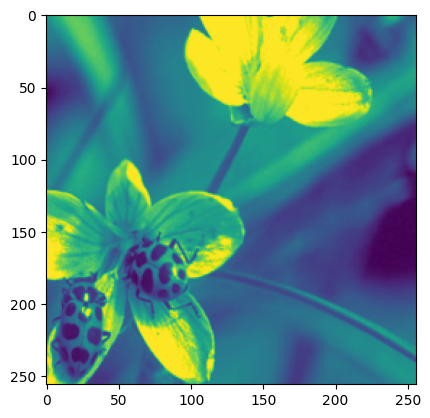

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(batch_image[0, 0, :, :].cpu().detach().numpy())

In [25]:
seed = 5 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (980, 980, 437, 437, 22, 22, 562, 562)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

B = 3
label_B = batch_labels
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
chw.show()